# Twitterでフォロワーをクラスタリングしてみた。

## 目次
---
- フォロワー同士の関係を取得
- クラスタリング
- 属性分析

In [325]:
import re
import os, sys
sys.path.append('../')

import psycopg2
import collections
from tqdm import tqdm

import MeCab
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## フォロワー同士の関係を取得
---

In [255]:
# 接続情報
connection_config = {
    'host': os.environ['RDS_HOST'],
    'port': '5432',
    'database': os.environ['RDS_DATABASE'],
    'user': os.environ['RDS_USERNAME'],
    'password': os.environ['RDS_PASSWORD']
}

conn = psycopg2.connect(**connection_config)

In [256]:
q_screen_name = 'rui_308'
q = "SELECT * FROM for_research.user_info where slave_screen_name='%s'" % q_screen_name

follower_df = pd.read_sql(sql=q, con=conn)

In [257]:
follower_df.head()

,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_description,protected
0,rui_308,1027812767661678592,chelios406,35,19,シェブ チェリオスです。充電しないと即停止します。面白いツイートはできません。基本、夜しか出...,0
1,rui_308,473583122,hasamarhythm,1080,794,みんなもレッツ諦念,0
2,rui_308,742897072228044800,ke_mirakao8,102,22,大学生。クリープハイプ/andymori/ナードマグネット/teto/リーガルリリー/Hel...,0
3,rui_308,3184817456,JSUBC,1194,1201,J-subculture,0
4,rui_308,3220618783,Luisthebestcat,81,44,I love it all japanese music like indigo la En...,0


In [258]:
follower_ids = follower_df['user_id']

In [440]:
q = "select * from for_research.friend_ids"

friends_df = pd.read_sql(sql=q, con=conn)

In [441]:
friends_df['com_friend_ids'] = friends_df['friend_ids'].str.split(',') \
    .apply(lambda x: np.array(x).astype(int)) \
    .apply(lambda x: list(set(x) & set(follower_ids)))

In [442]:
friends_df.head()

,user_id,screen_name,friend_ids,com_friend_ids
0,762311395354435584,ace_0815,"242298498,708952352288481280,84017558035607961...","[947833242278694912, 242298498, 85504930587848..."
1,942665865232760832,utsusemi_end,"559501103,480876175,912664232881094656,3145665...","[754466790403518464, 948638887, 3221413352, 23..."
2,804375248355213313,p_z4s3,"3308626946,2962184605,3145665278,9575947655030...","[933697292909010944, 941983908576370688, 82123..."
3,973092802925010945,fugutaruto0922,"1015164230041915394,1027199962168188930,953892...","[1032537382073982976, 868816424667455489, 1015..."
4,943103693464903681,1O_ooll,"986929396085747713,845294005210378241,85895520...","[788274867141349376, 924582695358697472, 81913..."


In [443]:
friends_df.shape

(395, 4)

In [263]:
friends_df.dtypes

user_id            int64
screen_name       object
friend_ids        object
com_friend_ids    object
dtype: object

In [264]:
print ('組み合せ総数：', friends_df['com_friend_ids'].apply(lambda x: len(x)).sum()/2)

組み合せ総数： 4929.5


## クラスタリング
---
1. `user_id`と`screen_name`が対応する辞書を作る
- `friends_df['com_friend_screen_name']`の定義
- グラフを定義
    - `q_screen_name`と対象フォロワーを繋げる
    - 対象フォロワー同士のエッジを追加

### user_idとscreen_nameが対応する辞書を作る
friends_df['com_friend_ids']に対応して、friends_df['com_friend_screen_name']を定義

In [444]:
dict_id_to_name = follower_df[['user_id', 'screen_name']].set_index('user_id').T.to_dict()

In [439]:
# screen_nameの呼び出し方法
dict_id_to_name[761867125589807104]['screen_name']

'ra_0y'

### friends_df['com_friend_screen_name']の定義

In [446]:
friends_df['com_friend_screen_name'] = friends_df['com_friend_ids'].apply(lambda x: [dict_id_to_name[i]['screen_name'] for i in x])

In [447]:
friends_df.head()

,user_id,screen_name,friend_ids,com_friend_ids,com_friend_screen_name
0,762311395354435584,ace_0815,"242298498,708952352288481280,84017558035607961...","[947833242278694912, 242298498, 85504930587848...","[aiueokrock, GOLDEN_PIGS, RyuyaK1208, aoboshi_s]"
1,942665865232760832,utsusemi_end,"559501103,480876175,912664232881094656,3145665...","[754466790403518464, 948638887, 3221413352, 23...","[yutokk00, shuhei_t_, arca__info, maropoti09, ..."
2,804375248355213313,p_z4s3,"3308626946,2962184605,3145665278,9575947655030...","[933697292909010944, 941983908576370688, 82123...","[sumika_______04, flumpool846, rock_RAD3612, s..."
3,973092802925010945,fugutaruto0922,"1015164230041915394,1027199962168188930,953892...","[1032537382073982976, 868816424667455489, 1015...","[K13ODA9hJR8qPJe, ALXD_Kick_Spin, FullspecHLD,..."
4,943103693464903681,1O_ooll,"986929396085747713,845294005210378241,85895520...","[788274867141349376, 924582695358697472, 81913...","[SUPERROCKBAND, toshiki_drum163, toumorocoshi4..."


### グラフを定義
1. `q_screen_name`と対象フォロワーを繋げる
- 対象フォロワー同士のエッジを追加

In [497]:
# グラフの定義
G_follower = nx.Graph()
targets = friends_df[['screen_name', 'com_friend_screen_name']]

for t, com_names in targets.values:
    for com_name in com_names:
        G_follower.add_edge(t, com_name)

In [498]:
cliques = nx.node_clique_number(G_follower)

In [519]:
cluster_dic = {}

for screen_name, cluster in cliques.items():
    if not cluster in cluster_dic.keys():
        cluster_dic[cluster] = list()
    cluster_dic[cluster].append(screen_name)
    

## 属性分析
----

### 言語処理
- プロフィールから名詞のみを抽出
    - self_discription -> nounsに変換

In [523]:
cluster_names = cluster_dic[2]

In [533]:
cluster_df = follower_df[follower_df.screen_name.isin(cluster_names)].reset_index()

In [535]:
cluster_df['self_description'][2]

"村上桜ヶ丘3年 バンドメンバー探してます【School's out 新潟@comekami_o】【ex:@03034Amazeドラム/ex:@dread__officialギターと歌】"

In [536]:
def get_nouns(sentence):
    mt = MeCab.Tagger(' -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
    mt.parse('')
    node = mt.parseToNode(sentence)

    nouns = list()
    while node:
        if node.feature.split(',')[0]=='名詞':
            nouns.append(node.surface)
        node = node.next

    dst = ','.join(nouns)
    return dst

In [537]:
cluster_df['nouns'] = cluster_df['self_description'].apply(lambda x: get_nouns(x))

In [538]:
cluster_df.head()

,index,slave_screen_name,user_id,screen_name,friends_count,followers_count,self_description,protected,nouns
0,8,rui_308,921326211405463552,siiiyami,694,698,始まりの奇跡 幻でもいい,0,"始まり,奇跡,幻"
1,9,rui_308,1020375026875260928,84aZku,828,679,邦ロック 🚹17 姉に会いたい,0,"邦,ロック,🚹,17,姉"
2,20,rui_308,762311395354435584,ace_0815,445,522,村上桜ヶ丘3年 バンドメンバー探してます【School's out 新潟@comekami_...,0,"村上,桜ヶ丘,3年,バンドメンバー,School,s,out,新潟,comekami,o,e..."
3,24,rui_308,546128916,aakipaniclimber,18395,19895,AK-POPっていう名前でカナダでアルバム制作中です！\nカナダからでも曲作りの依頼承ります...,0,"AK,POP,名前,カナダ,アルバム,制作,中,カナダ,曲作り,依頼,公式サイト,https..."
4,31,rui_308,142258204,nishieifukuJAM,9551,11299,2017年12月31日をもって閉店した新宿JAMですが、2018年6月1日西永福に移転しまし...,0,"2017年,12月31日,閉店,新宿JAM,2018年,6月1日,西永福,移転,03,630..."


In [540]:
all_description = ','.join(cluster_df.nouns.tolist())
all_description_list = all_description.split(',')

c = collections.Counter(all_description_list)

In [541]:
#半角小文字
def islower(s):
    lowerReg = re.compile(r'^[a-z]+$')
    return lowerReg.match(s) is not None

#半角数字
def isdigit(s):
    digitReg = re.compile(r'^[0-9]+$')
    return digitReg.match(s) is not None

In [542]:
cluster_words = c.most_common()

for word, cnt in tqdm(c.most_common()):
    if isdigit(word) or islower(word) or word.strip()=='':
        cluster_words.remove((word, cnt))

100%|██████████| 7801/7801 [00:00<00:00, 33426.57it/s]


In [549]:
cluster_words[:10]

[('ロック', 438),
 ('邦', 432),
 ('好き', 354),
 ('フォロー', 319),
 ('無言', 200),
 ('垢', 180),
 ('音楽', 160),
 ('バンド', 147),
 ('ライブ', 132),
 ('さん', 123)]

## 可視化

In [544]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [545]:
_all_description_list = all_description_list

for word in tqdm(_all_description_list):
    if isdigit(word) or islower(word) or word.strip()=='':
        all_description_list.remove(word)

 89%|████████▉ | 20918/23548 [00:00<00:00, 39448.81it/s]


In [546]:
fpath = "~/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc"
temp = ' '.join(all_description_list)
wordcloud = WordCloud(background_color="white", font_path=fpath, width=1200, height=800, ranks_only=True).generate(temp)

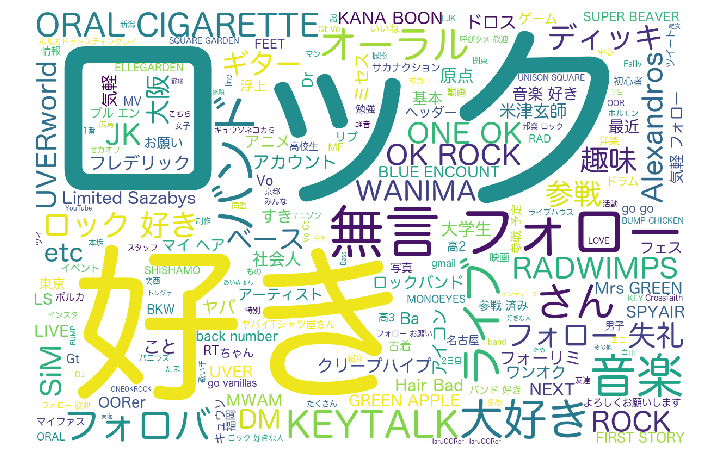

In [547]:
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()